# A Bidirectional Graph-Search Algorithm

We had some trouble with the slow identification of "simple paths" and "shortest paths" in our application, whereby we applied the common networkx library for python. We therefore developed our own bidirectional path search algorithms, for which we want provide a small benchmark at this post.

The algorithms can be downloaded under the following link

https://github.com/andre-dietrich/networkx/blob/master/networkx/algorithms/bidirectional_path_search.py

... we hope that these little helpers can be integrated into the networkx library.

## In principle

This algorithm depicted below constructs sequentially two trees, one from the source in direction to the target and one from the target in direction to the source. The leaves of both growing trees are continuously compared, if there are matching leaves in both trees, a new path is identified. Doing this, the algorithm actually reduces the search space by half, which should result in a faster identification of simple paths and shortest paths, compared to the original `nx.all_simple_paths` and  `nx.all_shortest_paths` algorithms (which are currently included in the networkx library). As revealed by the benchmark, this bidirectional search approach performs performs better for sparse trees, the more connected a graph is, the less beneficial is our approach.Another advantage is, that the results are returned in order, starting from the shortest paths, which are afterwards incremented stepwise in length.

## Usage

The principle of the bidirectional search was implemented for three common search tasks (`has_path`, `all_shortest_paths`, `all_simple_paths`). The application is briefly introduced within this section, before the three approaches are compared against their `networkx` counterparts.

Populating the interactive namespace from numpy and matplotlib


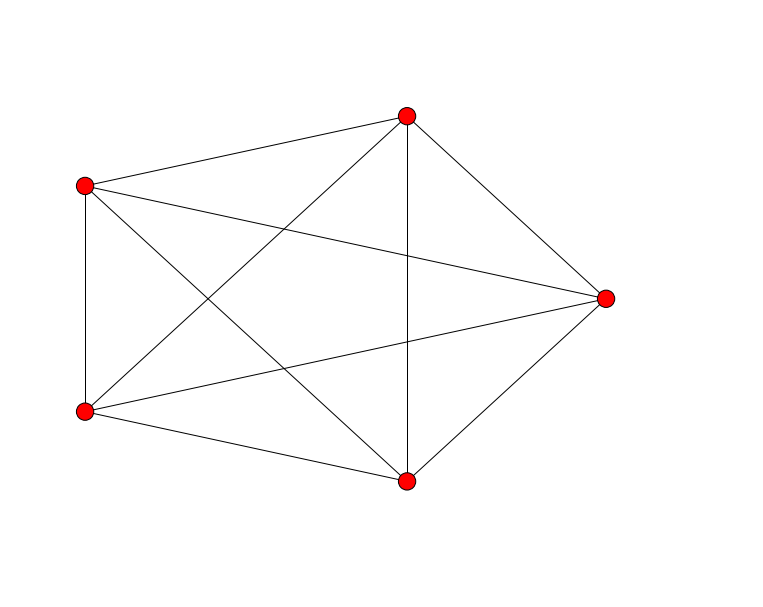

In [1]:
%pylab inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

#from bidirectional_path_search import *
 
import networkx as nx
G = nx.complete_graph(5)
 
import matplotlib.pyplot as plt
nx.draw_circular(G)

### 1. all_simple_paths

This function is used to search for all simple paths. A simple path, by definition, is a path with no repeated nodes. As visible in the example below, one benefit of the bidirectional approach is that all results are generated in order.

In [2]:
for path in nx.bidirectional_all_simple_paths(G, source=0, target=4):
    print(path)

[0, 4]
[0, 1, 4]
[0, 2, 4]
[0, 3, 4]
[0, 1, 2, 4]
[0, 1, 3, 4]
[0, 3, 1, 4]
[0, 3, 2, 4]
[0, 2, 1, 4]
[0, 2, 3, 4]
[0, 3, 1, 2, 4]
[0, 1, 3, 2, 4]
[0, 3, 2, 1, 4]
[0, 2, 3, 1, 4]
[0, 2, 1, 3, 4]
[0, 1, 2, 3, 4]


A similar example below, shows a the usage of the cutoff parameter, which is used to define a maximal path length

In [3]:
paths = nx.bidirectional_all_simple_paths(G, 0, 4,cutoff=2)
print(list(paths))

[[0, 4], [0, 1, 4], [0, 2, 4], [0, 3, 4]]


### 2. all_shortest_paths

`all_shortest_paths` is used similarly ... However, the implementation of this function contains some optimizations that cannot be applied in `all_simple_paths`, making it even faster.

In [4]:
for path in nx.bidirectional_all_shortest_paths(G, 0, 4):
    print(path)

[0, 4]


### 3. has_path

With this function we tried to port our concept onto a simple check of wheather a path between two nodes exists or not.

In [5]:
print nx.bidirectional_has_path(G, source=0, target=4)

True


### 4. Note

All of the presented algorithms can be applied in the same way also for directed graphs and multigraphs.

## Benchmark against networkx

The following benchmark is used to test the bidirectional approach against the implementation applied in networkx. For the test we applied the huge and dense graph that is generated below.

In [6]:
import time
import random
 
# trying out a huge graph...
G1 = nx.dense_gnm_random_graph(5000,5000,2)
print nx.info(G1)

Name: dense_gnm_random_graph(5000,5000)
Type: Graph
Number of nodes: 5000
Number of edges: 5000
Average degree:   2.0000


### 1. has_path – nearly equal (slightly)

As this first test reveals that our approach is a bit slower than the original `networkx.has_path` algorithm in identifying a connection between two nodes.

In [7]:
times1, times2 = [], []
for i in range(100000):
    source = random.randint(0, len(G1)-1)
    target = random.randint(0, len(G1)-1)
    
    # original
    t = time.time()
    r1 = nx.has_path(G1, source, target)
    times1.append(time.time()-t)
    
    # bidirectional
    t = time.time()
    r2 = nx.bidirectional_has_path(G1, source, target)
    times2.append(time.time()-t)

In [8]:
print "mean NetworkX:     ", mean(times1)
print "mean Bidirectional:", mean(times2)

mean NetworkX:      7.53516030312e-05
mean Bidirectional: 8.26878023148e-05


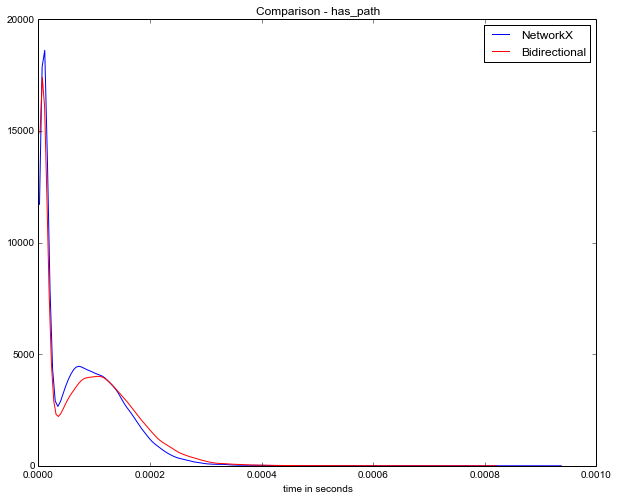

In [9]:
from scipy.stats import gaussian_kde
from numpy import linspace

plt.title("Comparison - has_path")
plt.xlabel("time in seconds")

density1 = gaussian_kde(times1)
xs1 = linspace(min(times1), max(times1), 200)
plt.plot(xs1, density1(xs1), label="NetworkX", color="blue")

density2 = gaussian_kde(times2)
xs2 = linspace(min(times2), max(times2), 200)
plt.plot(xs2, density2(xs2), label="Bidirectional", color="red")

plt.legend()
plt.show()

### 2. all_shortest_paths – win (approx. 60times faster)

In contrast to the previous approach, we now really perform much better, if it is about identifying all shortest paths within the graph. As you see from the mean value and mainly in the diagrams below, even with our worst approach we are below the minimum of the original search algorithm.

In [10]:
times1, times2     = [], []
results1, results2 = [], []
lengths1, lengths2 = [], []
for i in range(1000):
    source = random.randint(0, len(G1)-1)
    target = random.randint(0, len(G1)-1)
     
    if not nx.has_path(G1, source, target):
        continue
     
    # bidirectional
    t = time.time()
    res = list(nx.bidirectional_all_shortest_paths(G1, source, target))
    times2.append(time.time()-t)
    results2.append(len(res))
    lengths2.append(len(res[0]))
     
    # original
    t = time.time()
    res = list(nx.all_shortest_paths(G1, source, target))
    times1.append(time.time()-t)
    results1.append(len(res))
    lengths1.append(len(res[0]))

In [11]:
print "NetworkX:     ", mean(times1)
print "Bidirectional:", mean(times2)

NetworkX:      0.00706660211548
Bidirectional: 0.000267651654029


This difference becomes even more visible, when plotting the resulting times against the lengths of the shortest paths. It is still a mystery for us, why there are two clusters within the original algorithm.

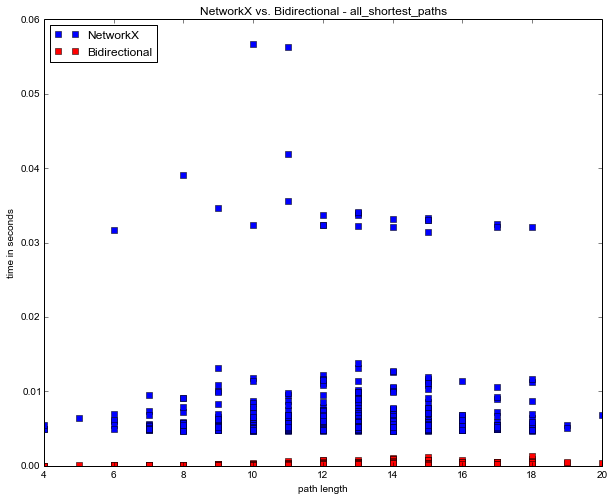

In [12]:
plt.plot(lengths1, times1, 'bs', label="NetworkX")
plt.plot(lengths2, times2, 'rs', label="Bidirectional")
plt.legend(loc="upper left")
plt.xlabel("path length")
plt.ylabel("time in seconds")
plt.title("NetworkX vs. Bidirectional - all_shortest_paths")
plt.show()

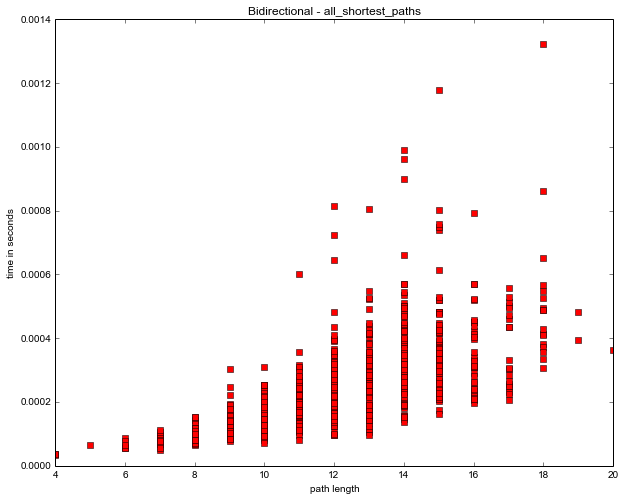

In [13]:
plt.plot(lengths2, times2, 'rs')
plt.xlabel("path length")
plt.ylabel("time in seconds")
plt.title("Bidirectional - all_shortest_paths")
plt.show()

### 3. `all_simple_paths` – tie game

For all simple paths, the bidirectional approach works fine until a certain cutoff number. The following example shows that we perform much better than the original approach, but this benefit is decreasing (slightly) with the number of cutoffs. The original approach shows a nearly linear effort (at least on a logarithmic scale) while ours in creases of cutoffs. That there is such a break even point, becomes especially apparent in the second example, which applies a much smaller graph, but with a higher connectivity…

In [14]:
node1 = 4; node2 = 1999
times3, times4, times5       = [0], [0], [0]
results3, results4, results5 = [0], [0], [0]
print "Cutoff\t #\tTime nx\t\t\tTime bi\t\t\tTime Yen"
for i in range(41):
    # original
    if times3[-1] < 1000:
        t = time.time()
        res = list(nx.all_simple_paths(G1, node1, node2, cutoff=i))
        times3.append(time.time()-t)
        results3.append(len(res))
    
    # bidirectional
    if times4[-1] < 1000:
        t = time.time()
        res = []
        for path in nx.bidirectional_all_simple_paths(G1, node1, node2):
            if len(path) > i+1: break
            res.append(path)
        times4.append(time.time()-t)
        results4.append(len(res))    
        
    # Yen
    if times5[-1] < 1000:
        t = time.time()
        res = []
        for path in nx.shortest_simple_paths(G1, node1, node2):
            if len(path) > i+1: break
            res.append(path)
        times5.append(time.time()-t)
        results5.append(len(res))
        
    #print results3[-1], results4[-1], results5[-1]     
    print "%2d\t%d\t%4.10f\t\t%4.10f\t\t%4.10f" % (i, results4[-1],
                                                      times3[-1],
                                                      times4[-1],
                                                      times5[-1])

Cutoff	 #	Time nx			Time bi			Time Yen
 0	0	0.0001938343		0.0001909733		0.0000870228
 1	0	0.0000109673		0.0001530647		0.0000679493
 2	0	0.0000169277		0.0001330376		0.0000720024
 3	0	0.0000331402		0.0001621246		0.0000929832
 4	0	0.0000600815		0.0001440048		0.0000679493
 5	0	0.0001280308		0.0001609325		0.0000729561
 6	0	0.0002520084		0.0001718998		0.0000789165
 7	1	0.0004818439		0.0005228519		0.0027899742
 8	1	0.0007011890		0.0004849434		0.0029869080
 9	1	0.0015540123		0.0005009174		0.0037901402
10	1	0.0031771660		0.0008111000		0.0053839684
11	3	0.0085320473		0.0009028912		0.0089941025
12	3	0.0084071159		0.0006060600		0.0080168247
13	7	0.0163750648		0.0014569759		0.0208339691
14	10	0.0285570621		0.0011739731		0.0244791508
15	20	0.0570390224		0.0021500587		0.0524320602
16	38	0.1068758965		0.0028641224		0.1164960861
17	77	0.2308080196		0.0068378448		0.2202749252
18	151	0.5080819130		0.0171198845		0.4897210598
19	275	0.9346671104		0.0286808014		0.9400749207
20	540	1.5483899117		0.0655190945

Plotting the result on a logarithmic scale ...

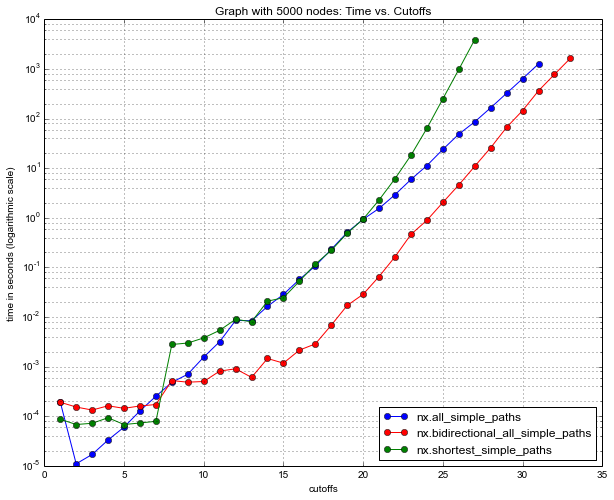

In [15]:
plt.title("Graph with 5000 nodes: Time vs. Cutoffs")
plt.ylabel("time in seconds (logarithmic scale)")
plt.xlabel("cutoffs")
plt.plot(range(len(times3)), times3, color="b", linestyle='-', marker='o', label="nx.all_simple_paths")
plt.plot(range(len(times4)), times4, color="r", linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
plt.plot(range(len(times5)), times5, color="g", linestyle='-', marker='o', label="nx.shortest_simple_paths")
plt.yscale('log')
plt.legend(loc="lower right")
plt.grid(True, which="both")
plt.show()

To show a more dramatical example we applied a much smaller graph with a higher connectivity rate. In essence it shows a similar behaviour, but for a certain number of results or cutoffs, our algorithm performs worse...

In [16]:
from networkx.utils import powerlaw_sequence
from networkx.utils import create_degree_sequence
 
def pick_nodes(G):
    u = next(G.nodes())
    v = next(nx.non_neighbors(G, u))
    return u, v
 
def build_power_law(n):
    deg_seq = create_degree_sequence(n, powerlaw_sequence, 100)
    G = nx.Graph(nx.configuration_model(deg_seq))
    G.remove_edges_from(G.selfloop_edges())
    G = max(nx.biconnected_component_subgraphs(G), key=len)
    G.name = 'Biconnected comp. of power law model: {0}'.format(n)
    return G
 
G2 = build_power_law(150)
u, v = pick_nodes(G2)
print(nx.info(G2))

Name: Biconnected comp. of power law model: 150
Type: Graph
Number of nodes: 86
Number of edges: 219
Average degree:   5.0930


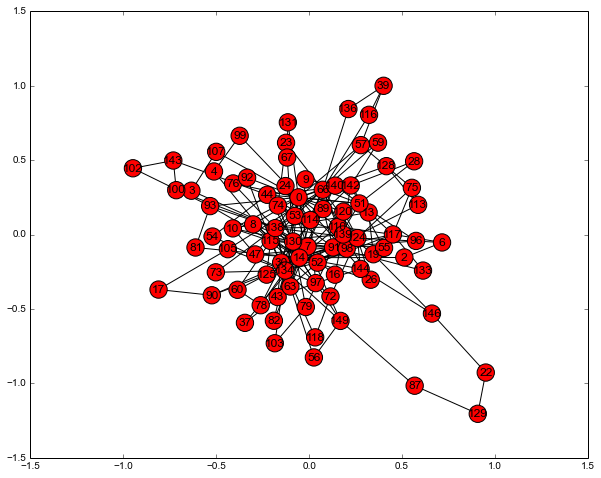

In [17]:
nx.draw_networkx(G2)

Repeating the experiment ...

In [18]:
times6, times7, times8       = [0], [0], [0]
results6, results7, results8 = [0], [0], [0]
print "Cutoff\t #\tTime nx\t\t\tTime bi\t\t\tTime Yen"
for i in range(21):
    # original
    if times6[-1] < 100:
        t = time.time()
        res = list(nx.all_simple_paths(G2, u, v, cutoff=i))
        times6.append(time.time()-t)
        results6.append(len(res))
    
    # bidirectional
    if times7[-1] < 100:
        t = time.time()
        res = []
        for path in nx.bidirectional_all_simple_paths(G2, u, v):
            if len(path) > i+1: break
            res.append(path)
        times7.append(time.time()-t)
        results7.append(len(res))    
        
    # Yen
    if times8[-1] < 100:
        t = time.time()
        res = []
        for path in nx.shortest_simple_paths(G2, u, v):
            if len(path) > i+1: break
            res.append(path)
        times8.append(time.time()-t)
        results8.append(len(res))
        
    #print results3[-1], results4[-1], results5[-1]     
    print "%2d\t%d\t%4.10f\t\t%4.10f\t\t%4.10f" % (i, results7[-1],
                                                      times6[-1],
                                                      times7[-1],
                                                      times8[-1])

Cutoff	 #	Time nx			Time bi			Time Yen
 0	0	0.5146319866		0.0001988411		0.0000631809
 1	0	0.0000159740		0.0000619888		0.0000441074
 2	0	0.0000510216		0.0000329018		0.0000331402
 3	9	0.0002379417		0.0000817776		0.0009310246
 4	70	0.0017499924		0.0003900528		0.0100638866
 5	453	0.0122740269		0.0021100044		0.1565241814
 6	2738	0.0820240974		0.0223660469		4.3153059483
 7	15529	0.5096459389		0.1255800724		204.2187178135
 8	83308	3.7868249416		1.1059770584		204.2187178135
 9	420645	18.9961390495		8.4237098694		204.2187178135
10	2006410	97.5954871178		66.1818208694		204.2187178135
11	9040207	514.5174510479		669.6574888229		204.2187178135
12	9040207	514.5174510479		669.6574888229		204.2187178135
13	9040207	514.5174510479		669.6574888229		204.2187178135
14	9040207	514.5174510479		669.6574888229		204.2187178135
15	9040207	514.5174510479		669.6574888229		204.2187178135
16	9040207	514.5174510479		669.6574888229		204.2187178135
17	9040207	514.5174510479		669.6574888229		204.2187178135
18	9040207	51

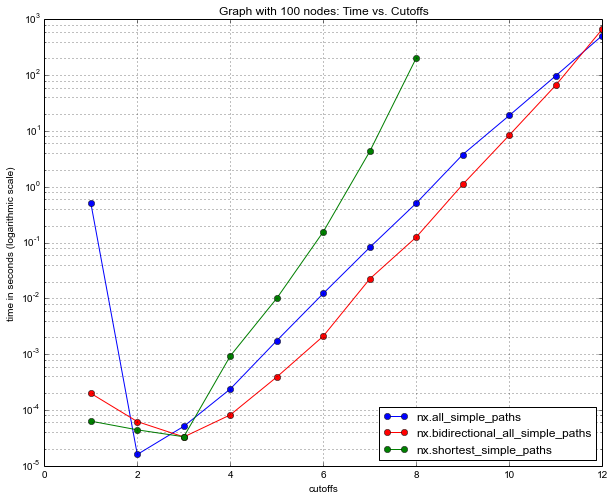

In [19]:
plt.title("Graph with 100 nodes: Time vs. Cutoffs")
plt.ylabel("time in seconds (logarithmic scale)")
plt.xlabel("cutoffs")
plt.plot(range(len(times6)), times6, color="b", linestyle='-', marker='o', label="nx.all_simple_paths")
plt.plot(range(len(times7)), times7, color="r", linestyle='-', marker='o', label="nx.bidirectional_all_simple_paths")
plt.plot(range(len(times8)), times8, color="g", linestyle='-', marker='o', label="nx.shortest_simple_paths")
plt.yscale('log')
plt.legend(loc="lower right")
plt.grid(True, which="both")
plt.show()